In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)


In [2]:
df = pd.read_csv("./news_stock_price.csv")

## Combine Lexicon/Finbert v1/Finbert v2

In [3]:
lexicon_df = pd.read_csv("lexicon/lexicon.csv")

finbertv1_df = pd.read_csv("model/finbertv1.csv")
finbertv2_df = pd.read_csv("model/finbertv2.csv")

def str_to_dict(s):
    s = s.replace("\'", "\"")
    d = json.loads(s)
    return d

def parse_result(series):
    dict_0, dict_1, dict_2 = [str_to_dict(s) for s in (series[0], series[1], series[2])]
    master_dict = {d["label"] : d["score"] for d in (dict_0, dict_1, dict_2)}
    
    return pd.Series(master_dict)

finbertv1_processed_df = finbertv1_df.apply(parse_result, axis=1)
finbertv2_processed_df = finbertv2_df.apply(parse_result, axis=1)

In [4]:
lexicon_df.columns = ["lexicon_" + col for col in lexicon_df.columns]
finbertv1_processed_df.columns = ["finbertv1_" + col for col in finbertv1_processed_df.columns]
finbertv2_processed_df.columns = ["finbertv2_" + col for col in finbertv2_processed_df.columns]

In [5]:
lexicon_df

,lexicon_neg,lexicon_neu,lexicon_pos,lexicon_compound
0,0.154,0.846,0.000,-0.4588
1,0.000,1.000,0.000,0.0000
2,0.000,0.926,0.074,0.2500
3,0.167,0.833,0.000,-0.2500
4,0.000,0.962,0.038,0.2500
...,...,...,...,...
145684,0.071,0.857,0.071,0.0000
145685,0.000,1.000,0.000,0.0000
145686,0.000,0.931,0.069,0.2500
145687,0.000,0.867,0.133,0.2500


In [6]:
finbertv1_processed_df

,finbertv1_negative,finbertv1_neutral,finbertv1_positive
0,0.619500,0.023500,0.357000
1,0.036809,0.934084,0.029107
2,0.014301,0.949441,0.036258
3,0.699227,0.279721,0.021052
4,0.824653,0.056331,0.119016
...,...,...,...
145684,0.006365,0.168140,0.825495
145685,0.006068,0.137593,0.856338
145686,0.008078,0.393455,0.598467
145687,0.008223,0.884564,0.107213


In [7]:
finbertv2_processed_df

,finbertv2_Negative,finbertv2_Neutral,finbertv2_Positive
0,1.948491e-07,2.602265e-08,9.999998e-01
1,5.996959e-06,9.999863e-01,7.732951e-06
2,6.777957e-06,9.996526e-01,3.405432e-04
3,2.265034e-02,9.773099e-01,3.971583e-05
4,4.510794e-03,9.954620e-01,2.722314e-05
...,...,...,...
145684,5.404326e-04,1.167704e-01,8.826891e-01
145685,3.957270e-09,2.228312e-08,1.000000e+00
145686,1.795362e-06,5.268962e-03,9.947293e-01
145687,2.331563e-07,9.999992e-01,5.875821e-07


In [8]:
combined_df = pd.concat([df, lexicon_df, finbertv1_processed_df, finbertv2_processed_df], axis=1)

combined_df["pct_return"] = combined_df["pct_return"] * 100

In [9]:
def parse_relevance_score(series):
    list_of_dict = str_to_dict(series["ticker_sentiment"])
    
    filter_list = [d for d in list_of_dict if d["ticker"] == series["symbol"]]
    
    assert len(filter_list) == 1
    
    d = filter_list[0]
    
    return d["relevance_score"]

combined_df["relevance_score"] = combined_df.apply(parse_relevance_score, axis=1).astype("float")

combined_df["relevance_score"].describe()

count    145689.000000
mean          0.226374
std           0.213776
min           0.000716
25%           0.071145
50%           0.142989
75%           0.308891
max           1.000000
Name: relevance_score, dtype: float64

In [10]:
master_df = combined_df.loc[combined_df["relevance_score"] > 0.5]

print(f"Before filtering: {len(combined_df):,}")
print(f"After filtering: {len(master_df):,}")
len(master_df)

Before filtering: 145,689
After filtering: 18,517


18517

## Correlation

### Lexicon - score -> label

- positive sentiment: compound score >= 0.05
- neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
- negative sentiment: compound score <= -0.05

### Finbert - label probability 
- Negative: p1
- Neutral: p2
- Positive: p3

p1+p2+p3=1

Label an article as pos/neg only if the probablity is higher than the threshold (0.8)

### Stock price - percentage return

- 25th percentile -0.18%
- 75th percentile 0.19%

- Negative: < -0.5%
- Neutral: -0.5% to 0.5% 
- Positive: > 0.5%


### Analysis

To simplify the multi-class classification problem, we transform this into a binary classification problem.

Firstly, we remove neutral price movements since we are not interested in predicting this specific event.

For news articles which has significant price movement (absolute percentage return bigger than 0.5% in the 25 minute window), we feed into the lexicon-based and model-based sentiment analysis algorithm.

The algorithm will classify them into three classes (positive, neutral, negative). We remove articles labelled as neutral by the algorithm and evaluate its accuracy on positive or negative articles.

In [11]:
print(100*master_df["pct_return"].describe())
print("\n")

def return_dist(master_df):
    pos_threshold = 0.2
    neg_threshold = -0.2
        
    # neutral 
    neutral_count = len(master_df.loc[(master_df["pct_return"] > neg_threshold) & (master_df["pct_return"] < pos_threshold)])

    # positive
    pos_count = len(master_df.loc[master_df["pct_return"] > pos_threshold])

    # negative
    neg_count = len(master_df.loc[master_df["pct_return"] < neg_threshold])

    print(f"Positive: {pos_count}, Negative: {neg_count}, Neutral: {neutral_count}")
    
return_dist(master_df)

count    1.851700e+06
mean     3.293022e-01
std      5.013935e+01
min     -9.341420e+02
25%     -1.931667e+01
50%      0.000000e+00
75%      1.982166e+01
max      1.560388e+03
Name: pct_return, dtype: float64


Positive: 4613, Negative: 4523, Neutral: 9380


## target

In [12]:
def create_target_label(master_df):
    master_df = master_df.copy()
    pos_threshold = 0.2
    neg_threshold = -0.2
    
    # create a list of our conditions
    conditions = [
        (master_df["pct_return"] > neg_threshold) & (master_df["pct_return"] < pos_threshold),
        master_df["pct_return"] >= pos_threshold,
        master_df["pct_return"] <= neg_threshold,
        ]

    # create a list of the values we want to assign for each condition
    values = ['neu', 'pos', 'neg']

    # create a new column and use np.select to assign values to it using our lists as arguments
    master_df['target_label'] = np.select(conditions, values)

    master_df['target_label'].value_counts()
    
    return master_df

master_df = create_target_label(master_df)

In [13]:
target_df = master_df.loc[master_df['target_label'].isin(["pos", "neg"])].copy()
target_df["target_label"].value_counts()

pos    4614
neg    4523
Name: target_label, dtype: int64

## lexicon

In [14]:
target_df["lexicon_compound"].describe()

count    9137.000000
mean        0.036932
std         0.209811
min        -0.790600
25%         0.000000
50%         0.000000
75%         0.250000
max         0.790600
Name: lexicon_compound, dtype: float64

In [15]:
def create_lexicon_label(target_df):
    # create a list of our conditions
    conditions = [
        (target_df["lexicon_compound"] > -0.05) & (target_df["lexicon_compound"] < 0.05),
        target_df["lexicon_compound"] >= 0.05,
        target_df["lexicon_compound"] <= -0.05,
        ]

    # create a list of the values we want to assign for each condition
    values = ['neu', 'pos', 'neg']

    # create a new column and use np.select to assign values to it using our lists as arguments
    target_df['lexicon_label'] = np.select(conditions, values)

    target_df['lexicon_label'].value_counts()
    
    return target_df

target_df = create_lexicon_label(target_df)
target_df['lexicon_label'].value_counts()

neu    5415
pos    2376
neg    1346
Name: lexicon_label, dtype: int64

## finbertv1

In [16]:
# master_df["finbertv1_label"] = master_df[['finbertv1_negative', 'finbertv1_neutral', 'finbertv1_positive']].idxmax(axis=1)

# finbertv1_label_mapping = {
#     'finbertv1_negative':'neg',
#     'finbertv1_neutral':'neu',
#     'finbertv1_positive':'pos',
# }
# master_df["finbertv1_label"] = master_df["finbertv1_label"].map(finbertv1_label_mapping)

# master_df["finbertv1_label"].value_counts()

def classify_prob(s, pos_col, neg_col, prob_threshold):
    if s[pos_col] > prob_threshold:
        return 'pos'
    elif s[neg_col] > prob_threshold:
        return 'neg'
    else:
        return 'neu'

target_df["finbertv1_label"] = target_df.apply(classify_prob, pos_col='finbertv1_positive', neg_col='finbertv1_negative', prob_threshold=0.8, axis=1)    
    
target_df["finbertv1_label"].value_counts()

neu    5058
pos    2353
neg    1726
Name: finbertv1_label, dtype: int64

## finbertv2

In [17]:
# master_df["finbertv2_label"] = master_df[['finbertv2_Negative', 'finbertv2_Neutral', 'finbertv2_Positive']].idxmax(axis=1)

# finbertv2_label_mapping = {
#     'finbertv2_Negative':'neg',
#     'finbertv2_Neutral':'neu',
#     'finbertv2_Positive':'pos',
# }
# master_df["finbertv2_label"] = master_df["finbertv2_label"].map(finbertv2_label_mapping)

# master_df["finbertv2_label"].value_counts()

target_df["finbertv2_label"] = master_df.apply(classify_prob, pos_col='finbertv2_Positive', neg_col='finbertv2_Negative', prob_threshold=0.8, axis=1)    
    
target_df["finbertv2_label"].value_counts()

pos    3814
neu    3384
neg    1939
Name: finbertv2_label, dtype: int64

In [18]:
for feature_col in ['lexicon_label', "finbertv1_label", "finbertv2_label"]:
    filtered_df = target_df.loc[target_df[feature_col].isin(["pos", "neg"])]
    print(feature_col)
    print(classification_report(filtered_df["target_label"], filtered_df[feature_col]))
    print('\n')

lexicon_label
              precision    recall  f1-score   support

         neg       0.52      0.38      0.44      1840
         pos       0.52      0.66      0.58      1882

    accuracy                           0.52      3722
   macro avg       0.52      0.52      0.51      3722
weighted avg       0.52      0.52      0.51      3722



finbertv1_label
              precision    recall  f1-score   support

         neg       0.49      0.43      0.45      1981
         pos       0.52      0.58      0.55      2098

    accuracy                           0.50      4079
   macro avg       0.50      0.50      0.50      4079
weighted avg       0.50      0.50      0.50      4079



finbertv2_label
              precision    recall  f1-score   support

         neg       0.51      0.35      0.42      2822
         pos       0.52      0.68      0.59      2931

    accuracy                           0.52      5753
   macro avg       0.51      0.51      0.50      5753
weighted avg       0.51 

lexicon_label


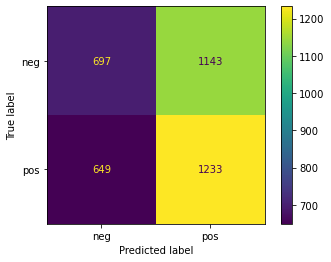

finbertv1_label


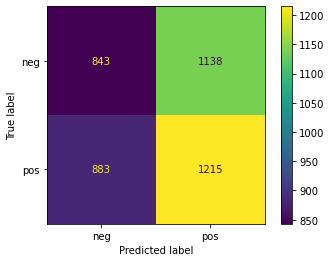

finbertv2_label


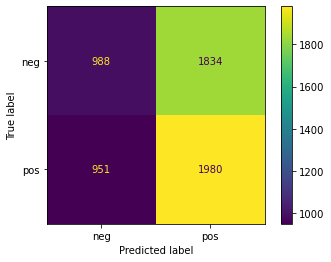

In [19]:
for feature_col in ['lexicon_label', "finbertv1_label", "finbertv2_label"]:
    filtered_df = target_df.loc[target_df[feature_col].isin(["pos", "neg"])]
    print(feature_col)
    cm = confusion_matrix(filtered_df["target_label"], filtered_df[feature_col], labels=["neg", "pos"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neg", "pos"])
    disp.plot()
    plt.show()

In [48]:
def check_error_source(target_df):
    error_dist_list = [] 
    for model in ["lexicon", "finbertv1", "finbertv2"]:
        fp = (target_df[f"{model}_label"]=="pos") & (target_df["target_label"]=="neg")
        fn = (target_df[f"{model}_label"]=="neg") & (target_df["target_label"]=="pos")
        error_df = target_df.loc[fp | fn]
        error_dist = error_df["source"].value_counts(normalize=True).rename(f"error_{model}")
        error_dist_list.append(error_dist)

    original_dist = target_df["source"].value_counts(normalize=True).rename("original")
    error_dist_list.append(original_dist)
    compare_df = pd.concat(error_dist_list, axis=1)
    
    return compare_df

compare_df = check_error_source(target_df)
compare_df

,error_lexicon,error_finbertv1,error_finbertv2,original
Zacks Commentary,0.344308,0.205839,0.242011,0.302287
Motley Fool,0.197545,0.184562,0.207899,0.200941
Benzinga,0.140625,0.259772,0.265709,0.229178
Barrons,0.062500,0.071252,0.060682,0.045639
Forbes,0.060268,0.069767,0.053860,0.042246
Stocknews.com,0.041853,0.045027,0.044524,0.038744
The Street,0.038504,0.047501,0.033752,0.032396
Investors Business Daily,0.032924,0.029193,0.028366,0.026157
MarketWatch,0.015067,0.016823,0.011490,0.010178
Associated Press,0.012835,0.007422,0.006463,0.015322


In [20]:
# check false positive for lexicon
target_df.loc[(target_df["lexicon_label"]=="pos") & (target_df["target_label"]=="neg")].sample(10)

,title,url,time_published,authors,summary,banner_image,source,category_within_source,source_domain,topics,overall_sentiment_score,overall_sentiment_label,ticker_sentiment,company,symbol,time_published_5min,date,datetime_before,open,high,low,close_before,volume,datetime_after,close_after,pct_return,lexicon_neg,lexicon_neu,lexicon_pos,lexicon_compound,finbertv1_negative,finbertv1_neutral,finbertv1_positive,finbertv2_Negative,finbertv2_Neutral,finbertv2_Positive,relevance_score,target_label,lexicon_label,finbertv1_label,finbertv2_label
53158,Should Value Investors Buy The Kroger Co. ( KR ) Stock?,https://www.zacks.com/stock/news/2069611/should-value-investors-buy-the-kroger-co-kr-stock,2023-03-23 13:40:12,['Zacks Investment Research'],"Here at Zacks, our focus is on the proven Zacks Rank system, which emphasizes earnings estimates and estimate revisions to find great stocks. Nevertheless, we are always paying attention to the latest value, growth, and momentum trends to underscore strong picks.",https://staticx-tuner.zacks.com/images/default_article_images/default223.jpg,Zacks Commentary,NaN,www.zacks.com,"[{'topic': 'Earnings', 'relevance_score': '0.875462'}, {'topic': 'Retail & Wholesale', 'relevance_score': '1.0'}, {'topic': 'Financial Markets', 'relevance_score': '0.929393'}]",0.238057,Somewhat-Bullish,"[{'ticker': 'TSCDF', 'relevance_score': '0.253646', 'ticker_sentiment_score': '0.215413', 'ticker_sentiment_label': 'Somewhat-Bullish'}, {'ticker': 'KR', 'relevance_score': '0.533241', 'ticker_sentiment_score': '0.262984', 'ticker_sentiment_label': 'Somewhat-Bullish'}]",Kroger Co.,KR,2023-03-23 13:40:00,2023-03-23 00:00:00,2023-03-23 13:40:00,48.805000,48.900000,48.805000,48.890000,78841.0,2023-03-23 14:05:00,48.740000,-0.306811,0.0,0.952,0.048,0.2500,0.013477,0.861994,0.124529,3.995579e-06,7.540821e-04,0.999242,0.533241,neg,pos,neu,pos
5347,Are You a Momentum Investor? This 1 Stock Could Be the Perfect Pick,https://www.zacks.com/stock/news/1991574/are-you-a-momentum-investor-this-1-stock-could-be-the-perfect-pick,2022-10-13 13:50:04,['Zacks Investment Research'],The Zacks Style Scores offers investors a way to easily find top-rated stocks based on their investing style. Here's why you should take advantage.,https://staticx-tuner.zacks.com/images/default_article_images/default162.jpg,Zacks Commentary,NaN,www.zacks.com,"[{'topic': 'Earnings', 'relevance_score': '0.310843'}, {'topic': 'Energy & Transportation', 'relevance_score': '1.0'}, {'topic': 'Financial Markets', 'relevance_score': '0.87644'}]",0.467432,Bullish,"[{'ticker': 'SLB', 'relevance_score': '0.597525', 'ticker_sentiment_score': '0.422228', 'ticker_sentiment_label': 'Bullish'}]",Schlumberger N.V.,SLB,2022-10-13 13:50:00,2022-10-13 00:00:00,2022-10-13 13:50:00,43.785578,43.884775,43.735979,43.820297,111227.0,2022-10-13 14:15:00,43.646702,-0.396152,0.0,0.840,0.160,0.4588,0.012252,0.898013,0.089735,1.944049e-05,1.752236e-04,0.999805,0.597525,neg,pos,neu,pos
60757,Should Value Investors Buy Arch Capital Group ( ACGL ) Stock?,https://www.zacks.com/stock/news/1975209/should-value-investors-buy-arch-capital-group-acgl-stock,2022-09-01 13:40:10,['Zacks Investment Research'],"Here at Zacks, our focus is on the proven Zacks Rank system, which emphasizes earnings estimates and estimate revisions to find great stocks. Nevertheless, we are always paying attention to the latest value, growth, and momentum trends to underscore strong picks.",https://staticx-tuner.zacks.com/images/default_article_images/default121.jpg,Zacks Commentary,NaN,www.zacks.com,"[{'topic': 'Earnings', 'relevance_score': '0.682689'}, {'topic': 'Finance', 'relevance_score': '1.0'}, {'topic': 'Financial Markets', 'relevance_score': '0.918141'}]",0.404909,Bullish,"[{'ticker': 'ACGL', 'relevance_score': '0.63878', 'ticker_sentiment_score': '0.375847', 'ticker_sentiment_label': 'Bullish'}]",Arch Capital Group Ltd.,ACGL,2022-09-01 13:40:00,2022-09-01 00:00:00,2022-09-01 13:40:00,45.515000,45.525000,45.500000,45.52